In [1]:
import modules
import numpy as np
import importlib
importlib.reload(modules)
from scipy.optimize import minimize


# design variables
x_name = ['x_wec','x_pen']
x_list = modules.variable_lookup(x_name)
x_list_default_values = modules.default_values(x_name)
x_list_bnds_values = modules.bnds_values(x_name)
x0 = []
x0_bnds = []
for i in range(len(x_list)):
    x0.append(x_list_default_values[x_list[i]])
    x0_bnds.append(x_list_bnds_values[x_list[i]])

# parameters
wec_types = ['attenuator','terminator','point absorber']

# fill default parameters
all_vars = ['x_wec','x_type_wec','x_pen','p_pen','x_env','p_wec','p_fish_salmon']

default_vars = []
for i in range(len(all_vars)):
    if all_vars[i] not in x_name:
        print(all_vars[i])
        default_vars.append(all_vars[i])

p = modules.default_values(default_vars)

# simulation
J = modules.obj(x0,x_name, p)

#optimization
opt_idx = 0
res={}
for i in range(len(wec_types)):
    p['wec_type'] = wec_types[i]
    
    arguments = (x_name, p)

    cons = ({'type': 'ineq', 'fun': modules.ineq_constraint, 'args': arguments},
            {'type': 'eq', 'fun': modules.eq_constraint, 'args': arguments})
    
    res[i] = minimize(modules.obj, x0, args=arguments, method='SLSQP', bounds=x0_bnds, constraints=cons)
    #print(res[i], '\n')
    
    if res[i].fun < res[opt_idx].fun:
        opt_idx = i


res[opt_idx]

x_type_wec
p_pen
x_env
p_wec
p_fish_salmon


     fun: array(743.72079276)
     jac: array([ 33.31334686, -77.04718781, -74.36236572])
 message: 'Positive directional derivative for linesearch'
    nfev: 251
     nit: 31
    njev: 27
  status: 8
 success: False
       x: array([22.3221026 , 19.30433389, 10.        ])

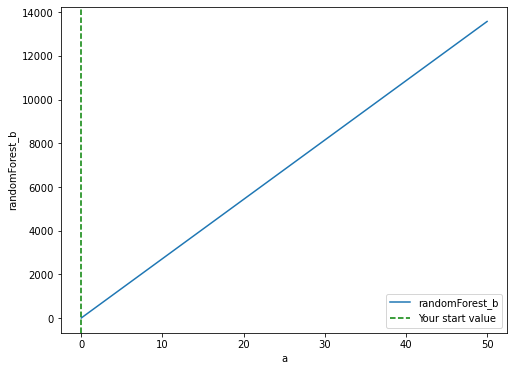

In [2]:
from matplotlib import pyplot as plt
a = np.linspace(0,50,51)
y_values = np.zeros(len(a))
x_name = ['x_wec','x_pen']
for i in range(len(a)):
    x0 = [a[i], 10, 10]
    y_values[i] = modules.obj(x0,x_name, p)
    #print(x0, y_values[i])

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(a, y_values, label='randomForest_b')
ax.axvline(0, label='Your start value', color='g', ls='--')
ax.set(xlabel='a', ylabel='randomForest_b');
ax.legend()